# Fixed point method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.xmargin'] = 0

We have seen that boundary value problems can be solved by setting up a matrix system of equations for each node. This approach can be generalised to higher dimensions, but it becomes challenging to implement.

As an alternative to using the simultaneous system of equations, the solution can often be found iteratively by starting with a suitable initial guess for the whole field $u$ and applying the finite difference formulae until (hopefully!) a fixed solution is determined.

An schematic illustration of the idea is provided below, based on the midpoint formula:
<br>

```{image} ../images/fixed_point.png
:alt: secant
:align: center
:scale: 70%
```
<br>

There are a few slightly different ways that the iterative steps can be performed, which are discussed in the subsections below.

To demonstrate the methods we will use the example problem given in {eq}`cdiffsin`. The finite difference scheme for this problem may be written asL

```{math}
:label: itsolver
u_k=\frac{u_{k+1}+u_{k-1}}{2}-\frac{h^2}{2}\sin(2\pi x_k), \quad u_0=u_n=0.
```

### Jacobi iteration
In Jacobi iteration, each iterative step uses only values from the "old" array. We take our starting guess for $u$ and apply it as a static input to the RHS of equation {eq}`itsolver` to obtain our new result for $u$. We repeat the method with our new result as the starting guess.

Here is an example of how the method could be implemented for our problem, taking our initial guess to be $u0=[0,0\dots,0,0]$ .The parameter `tol` sets a value for the desired level of convergence to achieve. You could adapt the code to add twiddles, such as counting the number of iterations and imposing a limit on the number:

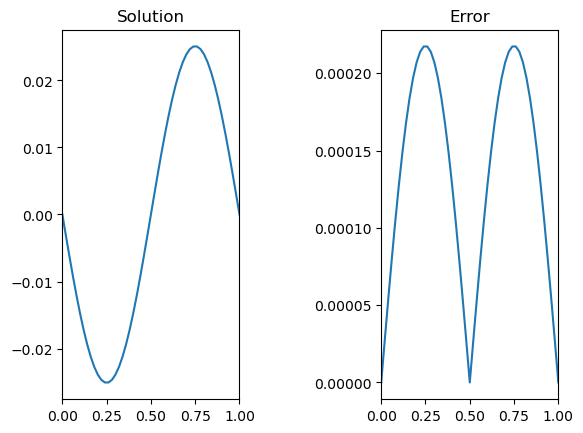

In [2]:
# Setting the grid space
n = 50
x = np.linspace(0,1,n+1)
h = x[1] - x[0]

# Initialize grid for iterative method
u0 = np.zeros(n+1)
k = h**2*np.sin(2*np.pi*x)

# Jacobi method
u1 = np.zeros(u0.shape)                      #Initialize

tol=1e-5                                     #Error tolerance
err=1                                        #Initialise

while err>tol:
    u1[1:-1]=(u0[2:]+u0[0:-2]-k[1:-1])/2         #Update rule
    err = np.linalg.norm(u1-u0)                  #Error
    u0[:]=u1[:]                                  #Re-initialise

# Plot and compare to the analytic solution
sol = -np.sin(2*np.pi*x)/4/np.pi**2;
fig,ax = plt.subplots(1,2)
ax[0].plot(x,u0)
ax[0].set_title('Solution')
ax[1].plot(x,np.abs(u0-sol))
ax[1].set_title('Error')

# set the spacing between subplots
plt.subplots_adjust(wspace=0.8)
plt.show()

### Gauss-Seidel

To speed up convergence, the iterations can be applied sequentially to each grid-point; for example by sweeping from left to right in the domain and updating each grid point in turn. This technique is known as the Gauss-Seidel method.

Grid values are updated "in-place" as we sweep left to right, and the updated result at each point is fed into the subsequent calculation.

<br>

```{image} ../images/GS1.gif
:alt: secant
:align: center
:scale: 30%
```
<br>

A code that implements this algorithm is provided below.

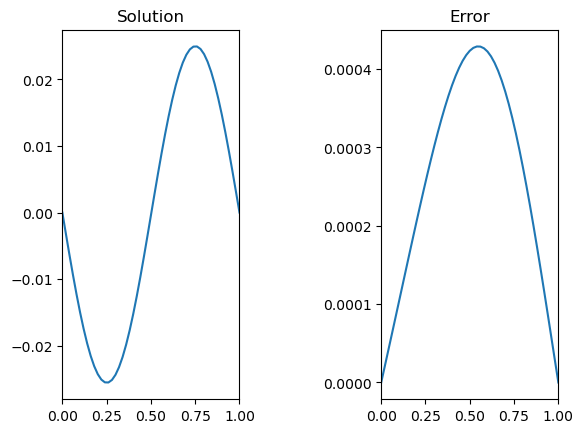

In [3]:
# Setting the grid space
n = 50
x = np.linspace(0,1,n+1)
h = x[1] - x[0]

# Initialize grid for iterative method
u0 = np.zeros(n+1)
k = h**2*np.sin(2*np.pi*x)

# Gauss-Seidel method
u1 = np.zeros(u0.shape)                      #Initialize

tol=1e-5                                     #Error tolerance
err=1                                        #Initialise

while err>tol:
  u1[:]=u0[:]                                #Make an array copy
  for i in range(1,len(u1)-1):
    u1[i] = (u1[i-1]+u1[i+1]-k[i])/2         #Update rule in place on u1     
  err = np.linalg.norm(u1-u0)                #Error
  u0[:]=u1[:]                                #Re-initialise

# Plot and compare to the analytic solution
sol = -np.sin(2*np.pi*x)/4/np.pi**2;
fig,ax = plt.subplots(1,2)
ax[0].plot(x,u0)
ax[0].set_title('Solution')
ax[1].plot(x,np.abs(u0-sol))
ax[1].set_title('Error')

# set the spacing between subplots
plt.subplots_adjust(wspace=0.8)
plt.show()

### Successive relaxation

A less obvious improvement in the technique, known as *sucessive relaxation*, starts with the observation that in each update step we obtain a relationship of the form

```{math}
u_{i,j}^{(new)}=u_{i,j}^{(old)}+r_{i,j},
```
where $r_{i,j}$ is the residual error. The proposal allows that faster convergence might be obtained by adjusting the update step in proportion to the size of the residual calculated from GS algorithm, which is supposed to converge to zero:

```{math}
:label: relax
u_{i,j}^{(new)}=u_{i,j}^{(old)}+\gamma r_{i,j},
```

The relaxation parameter $\gamma$ is selected for faster convergence, with

* $\gamma>1$ over-relaxation,
* $\gamma=1$ gives the ordinary GS method,
* $\gamma<1$ under-relaxation.

It is difficult to predict the optimum value of $\gamma$, but values in the range $(1,2)$ typically work well.

```{admonition} Note
In this case (and some others) the optimum parameter for Successive Over-Relaxation (SOR) can be predicted from the coefficient matrix.
```

In [4]:
M = np.diag(np.hstack((1,-2*np.ones(n-1),1)),k=0) + \
    np.diag(np.hstack((np.ones(n-1),0)),     k=-1)+ \
    np.diag(np.hstack((0,np.ones(n-1))),  k=1)

C = np.eye(n+1)-np.linalg.lstsq(np.diag(np.diag(M)),M, rcond=None)[0]
m = np.max(np.abs(np.linalg.eig(C)[0]))
sor = 1+m**2/(1+np.sqrt(1-m**2))**2
print(sor)

1.8818383898322146


## Chapter exercise

Apply a Gauss-Seidel relaxation technique with 51 radial points to determine the solution to {eq}`heateqn` to within $10^{-4}$.